Part 1

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [30]:
class Value:
    def __init__(self,data,_children=(),_op ='',label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    
    def __rmul__(self,other):
        return self * other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), 'only support int / float powers for now'
        out = Value(self.data**other,(self,), f'**{other}')
        def _backward():
            self.grad +=  other*(self.data**(other-1))*out.grad  
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self*other**-1
    
    def sin(self,_input=1):
        x = self.data
        x_in = x*_input
        s = math.sin(x_in)
        out = Value(s,(self,),'sine')
        def _backward():
            self.grad += _input * math.cos(x_in)
        out._backward = _backward
        return out



    def tanh(self):
        x = self.data
        t = ((math.exp(2*x)-1)) / ((math.exp(2*x)+1))
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [31]:
a = Value(2.0,label='a')
b = Value(3.0,label = 'b')
c = Value(4.0,label = 'c')
d = b.sin(3)
e = -a**3 + -1* c.__pow__(-1) + b**2.5 - a**0.5
o = d + e 

print(o.data)

6.336362190988558


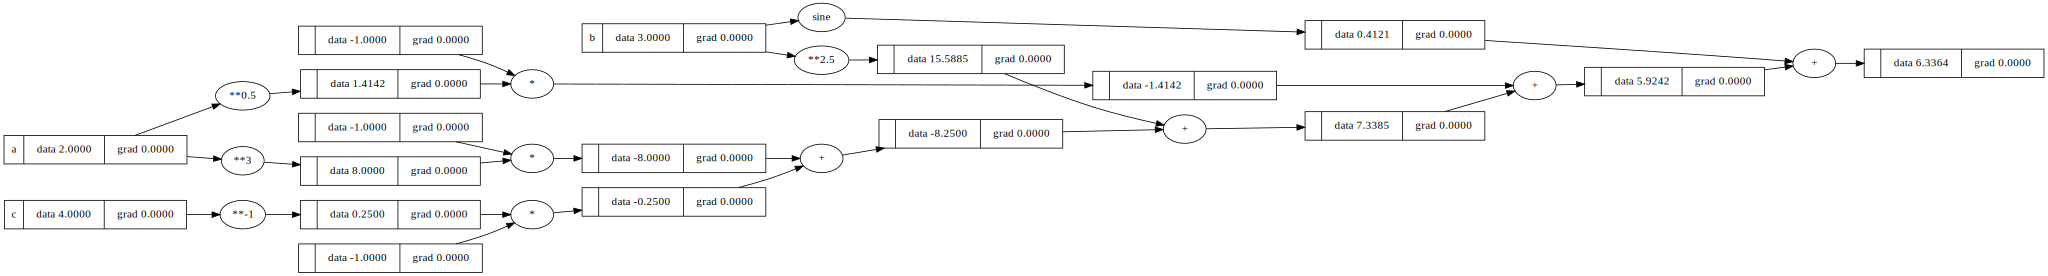

In [35]:
draw_dot(o)

In [36]:
o.backward()

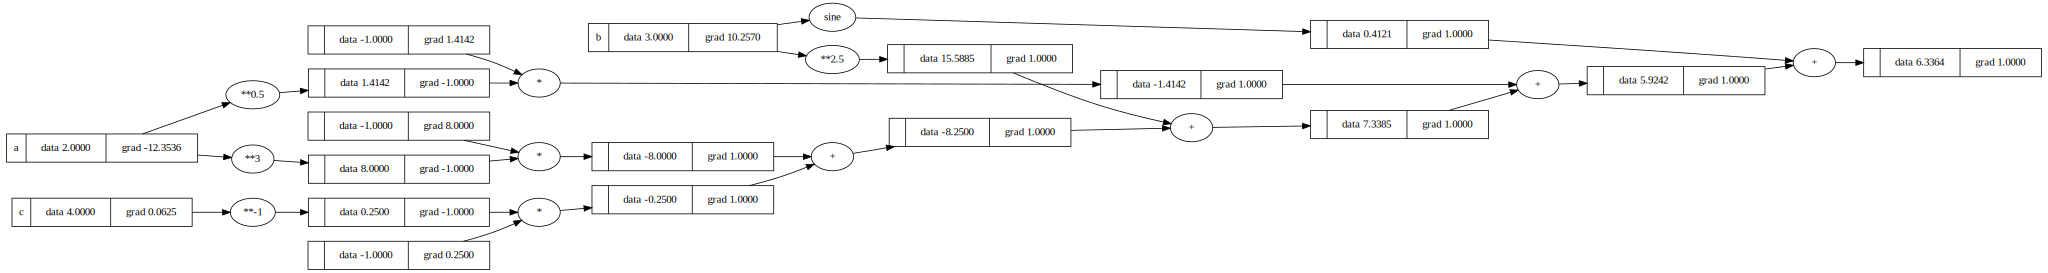

In [37]:
draw_dot(o)

In [38]:
print([a.grad,b.grad,c.grad])

[-12.353553390593273, 10.25699027111255, 0.0625]
